In [125]:
# import the json module
import json
# import the MAAP package
from maap.maap import MAAP
from maappy_helpers import fetch_results
from difflib import SequenceMatcher

# Testing MAAP Data System Services and Applications

The goal of this notebook is to assert that all the MAAP Data System Services are operating as expected in a given environment.


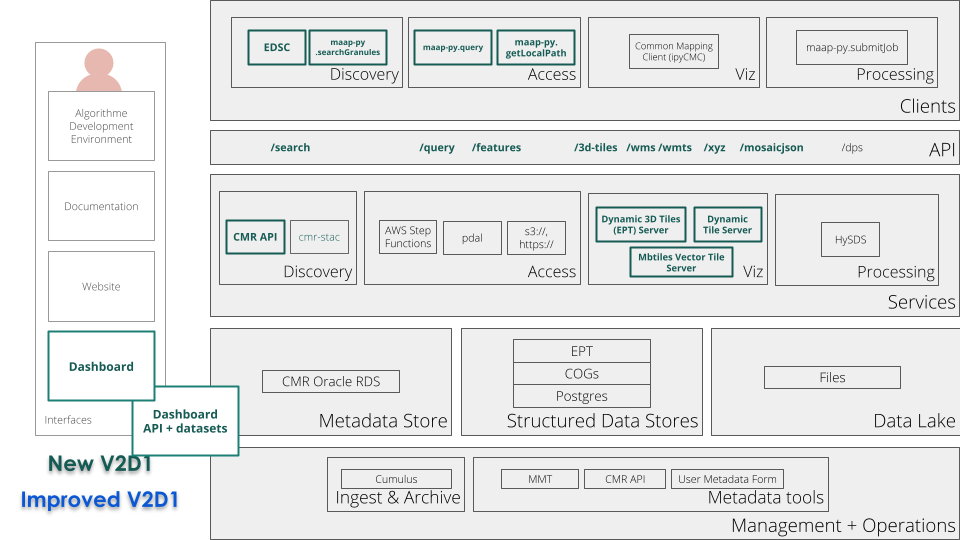

In [88]:
import os

# Gitlab CI should This should be set by CI
os.environ['ENV'] = 'dit'
if os.getenv('ENV') == 'dit':
    env_prefix = ''
elif os.getenv('ENV') == 'ops':
    env_prefix = 'ops.'

# Test different environments

TODO: We can use `MAAP(maap_host='api.ops.maap-project.org')` to test a different API endpoint.

For each piece of functionality we want to assert:

- maap-py is configured with the right API endpoint
- maap-py utility functions have the expected results
- (configured) API endpoint has the expected results

In [89]:
# create MAAP class
maap = MAAP(maap_host=f'api.{env_prefix}maap-project.org')

In [116]:
# Helper function for testing
def try_test_actual(test, actual, expected, comparator = "equal"):
    try:
        if comparator == "equal":
            assert actual == expected
        elif comparator == "greater_than_or_equal":
            assert actual >= expected
    except Exception as e:
        print(f"{test} {actual} is not {comparator} to {expected}")
        raise e

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Testing maap-py

Use the settings in https://github.com/MAAP-Project/maap-py/blob/master/maap/maap.py to test maap-py

In [111]:
expected_host = f'api.{env_prefix}maap-project.org'   
    
try_test_actual("_MAAP_HOST", maap._MAAP_HOST, expected_host)

# Test some basic search results


In [118]:
# Test endpoints
assert maap._SEARCH_GRANULE_URL == f'https://api.{env_prefix}maap-project.org/api/cmr/granules'
assert maap._SEARCH_COLLECTION_URL == f'https://api.{env_prefix}maap-project.org/api/cmr/collections'
# Test maap-py results
COLLECTIONID = 'C1200116818-NASA_MAAP' # specify the collection id for the ATLAS dataset

granule_search_results = maap.searchGranule(concept_id=COLLECTIONID, limit=500)
try_test_actual("granule search results", len(granule_search_results), 500)

collection_search_results = maap.searchCollection()
try_test_actual("collection_search_results", len(collection_search_results), 61, "greater_than_or_equal")

## Todo: Test Basic CMR Ingest Functions

# Test Algorithms and Data Processing System

TODO

In [6]:
# maap._ALGORITHM_REGISTER

# maap._ALGORITHM_BUILD

# maap._MAS_ALGO

# maap._DPS_JOB

# Test Members

TODO

In [7]:
# maap._MEMBER

# Test Query Endpoint

In [92]:
assert maap._QUERY_ENDPOINT == f'https://api.{env_prefix}maap-project.org/api/query/'

In [93]:
collection  = { 
  "Collection": { 
      "ShortName": "GEDI Cal/Val Field Data_1", 
      "VersionId": "2" 
  } 
}

query = {
    "bbox": [9.31, 0.53, 9.32, 0.54],
    "fields": ["project"]
}

In [119]:
results = fetch_results(maap, collection, query)

try_test_actual("Length of query search results", len(results), 258)
try_test_actual("Result of project query:", results[0], { 'project': 'gabon_mondah' })

# Test WMTS and tiler endpoints

Todo: Add test for WMS

In [120]:
assert maap._WMTS == f'https://api.{env_prefix}maap-project.org/api/wmts'

In [127]:
import requests

# this file was downloaded from the API docs (swagger)
xml = open('getCapabilities.xml', 'r')
expected_get_capabilities_xml = xml.read()
get_capabiities_response = requests.get(f'{maap._WMTS}/GetCapabilities')
try_test_actual("wmts/GetCapabilities response", get_capabiities_response.status_code, 200)

In [128]:
# Todo: figure out why these things are different
similarity_measure = similar(get_capabiities_response.text, expected_get_capabilities_xml)
try_test_actual("XML Response from GetCapabilities", similarity_measure, 0.86, "greater_than_or_equal")

In [62]:
# TODO: I think we want to remove this, this is only used by https://github.com/MAAP-Project/maap-py/blob/master/maap/maap.py#L438
# TODO: This should be different for 'ops'
# assert maap._TILER_ENDPOINT == 'https://8e9mu91qr6.execute-api.us-east-1.amazonaws.com/production'

# Test 3D-Tiles

In [ ]:
# TODO
# assert maap._3DTILES_ENDPOINT == 'https://api.maap-project.org/api/3d-tiles'

In [129]:
# peru and global are other endpoints
threed_tiles_endpoint = 'https://llxbmdibvf.execute-api.us-east-1.amazonaws.com/test/file-staging/nasa-map/ATL08_ARD-beta___001/afrisar/ept/ept-tileset/tileset.json'

In [132]:
tileset_response = requests.get(threed_tiles_endpoint)

try_test_actual("3D-tiles tileset response status", tileset_response.status_code, 200)
try_test_actual("3D-tiles tileset response keys", list(json.loads(tileset_response.text).keys()), ['asset', 'geometricError', 'root'])

# Test Features

In [133]:
# To implement

# assert maap._FEATURES_ENDPOINT == 'https://api.maap-project.org/api/collections'

features_endpoint = 'https://8k07ljl96e.execute-api.us-east-1.amazonaws.com/collections'
items_endpoint = f'{features_endpoint}/AfriSAR/items?f=json'
items_response = requests.get(items_endpoint)

try_test_actual("Features items response status", items_response.status_code, 200)
try_test_actual("Features items response type", json.loads(items_response.text)['type'], 'FeatureCollection')


# Test Vector Tiles

TODO

# Test Services

## MMT

In [136]:
url = f'https://mmt.{env_prefix}maap-project.org'
mmt_response = requests.get(url)
try_test_actual("MMT Response", mmt_response.status_code, 200)

## UMF

In [135]:
url = f'https://questionnaire.{env_prefix}maap-project.org'
umf_response = requests.get(url)
try_test_actual("UMF Response", umf_response.status_code, 200)

## EDSC

In [134]:
url = f'https://search.{env_prefix}maap-project.org'
edsc_response = requests.get(url)
try_test_actual("EDSC Response", edsc_response.status_code, 200)

# Laundry List

## As part of this notebook work

- ~Error handling to assertions~
- [ ] Add to an operator manual handling of failures
- [ ] Add this to maap-data-system-services and / or the maap-api-nasa repo and instructions for running it to that repo
- [ ] Add to MAAP concept operations document / operator guide
- [ ] How to develop on maap-api-nasa - do we run our own instance of the API in UAH? What do we need to know about https://repo.nasa.maap.xyz/root/maap-api-nasa

## Longer term

- [ ] We should have a data system api which acts as a "discovery service" so that the api.maap-project.org or other systems can discover backend APIs w/o hard-coding API gateway in configs.
- [ ] How doe we test the endpoints are configured in 'https://github.com/MAAP-Project/maap-api-nasa/blob/master/api/settings.py'
- [ ] Some sort of browser test (Capybara, Cypress?) for applications 